In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optax

from jax import jit, vmap, random
import jax.numpy as jnp

from src.net import NeuralNetwork

# Compiling and vmap-ing

In [ ]:
key = random.PRNGKey(0)
X = random.normal(key, (100, 10,))
y = random.normal(key, (100, 1,)) + 1

In [ ]:
key = random.PRNGKey(1)
net = NeuralNetwork([10, 20, 1], key)
net

In [5]:
%%timeit

for x in X:
    net(x)

18.1 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
v_net = vmap(net)

%timeit v_net(X)

1.56 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
fast_net = net.compile()

%timeit fast_net(X)

64 µs ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


: 

# Optimization Input

In [3]:
with open('opt_input.json') as f:
    opt_input = json.load(f)

[k for k in opt_input.keys() if 'table' in k]

['executables',
 'table_n_qgl_whp_to_qo',
 'table_n_qgl_whp_to_qo_with_dss',
 'table_n_bcs_whp_to_qo',
 'table_n_bcs_whp_to_qo_with_dss',
 'table_manifold_delta_p']

In [4]:
df = pd.DataFrame(opt_input['table_manifold_delta_p']['0'])
for col in df:
    print(col)
    print(df[col].unique())

psup
[10. 20. 30. 40. 50. 60.]
rgl
[ 50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170. 180.
 190. 200. 210. 220. 230. 240. 250. 260. 270. 280. 290. 300. 310. 320.
 330. 340.]
bsw
[0.3 0.4 0.5 0.6]
qliq
[ 300.  800. 1300. 1800. 2300. 2800. 3300. 3800. 4300. 4800. 5300. 5800.]
delta_p
[101.69076381 103.16402642 106.02287647 ... 267.38467273 277.58310052
 289.96663611]


In [47]:
from delta_p_curve import delta_p_curve_points

df = pd.DataFrame(delta_p_curve_points)
for col in df:
    print(col, df[col].unique())

psup [10. 20. 30. 40. 50. 60.]
rgl [ 50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170. 180.
 190. 200. 210. 220. 230. 240. 250. 260. 270. 280. 290. 300. 310. 320.
 330. 340.]
bsw [0.3 0.4 0.5 0.6]
qliq [ 300.  800. 1300. 1800. 2300. 2800. 3300. 3800. 4300. 4800. 5300. 5800.]
delta_p [101.69076381 103.16402642 106.02287647 ... 267.38467273 277.58310052
 289.96663611]


# Training

In [48]:
df

,psup,rgl,bsw,qliq,delta_p
0,10.0,50.0,0.3,300.0,101.690764
1,10.0,50.0,0.4,300.0,103.164026
2,10.0,50.0,0.5,300.0,106.022876
3,10.0,50.0,0.6,300.0,110.714479
4,10.0,60.0,0.3,300.0,93.724057
...,...,...,...,...,...
8635,60.0,330.0,0.6,5800.0,284.403585
8636,60.0,340.0,0.3,5800.0,258.492570
8637,60.0,340.0,0.4,5800.0,267.384673
8638,60.0,340.0,0.5,5800.0,277.583101


In [6]:
df_norm = df.copy()

for col in df:
    # scale to [ 0, 1]
    df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    # scale to [-1, 1]
    df_norm[col] = 2 * df_norm[col] - 1

df_norm

,psup,rgl,bsw,qliq,delta_p
0,-1.0,-1.000000,-1.000000,-1.0,-0.537628
1,-1.0,-1.000000,-0.333333,-1.0,-0.527487
2,-1.0,-1.000000,0.333333,-1.0,-0.507808
3,-1.0,-1.000000,1.000000,-1.0,-0.475513
4,-1.0,-0.931034,-1.000000,-1.0,-0.592468
...,...,...,...,...,...
8635,1.0,0.931034,1.000000,1.0,0.720083
8636,1.0,1.000000,-1.000000,1.0,0.541724
8637,1.0,1.000000,-0.333333,1.0,0.602933
8638,1.0,1.000000,0.333333,1.0,0.673134


In [7]:
X = df_norm[['psup', 'rgl', 'bsw', 'qliq']].values
y = df_norm['delta_p'].values

X = jnp.array(X)
y = jnp.array(y)[...,None]

X.shape, y.shape

((8640, 4), (8640, 1))

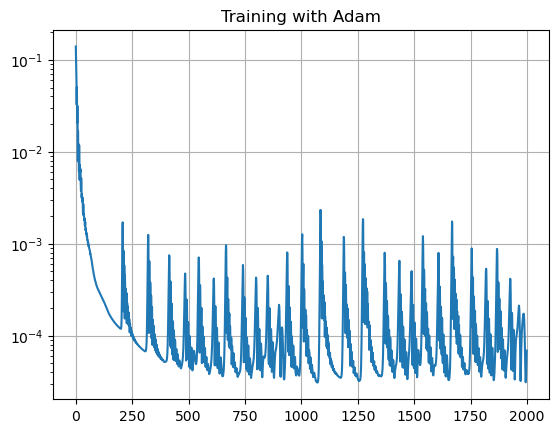

In [8]:
key = random.PRNGKey(1)
net = NeuralNetwork([4, 100, 1], key)

optimizer = optax.adam(learning_rate=1e-1)

loss_values = net.fit(optimizer, optax.l2_loss, X, y, epochs=2000)

plt.plot(loss_values)
plt.yscale('log')
plt.title('Training with Adam')
plt.grid()
plt.show()

In [9]:
predict = net.compile()
y_hat = predict(X)

y_hat = (y_hat + 1) / 2
y_hat = y_hat * (df['delta_p'].max() - df['delta_p'].min()) + df['delta_p'].min()
df['delta_p_hat'] = y_hat[:,0]

err = y_hat[:,0] - df['delta_p'].values

print('MAE =', np.abs(err).mean())
print('max error =', np.abs(err).max())

MAE = 1.586947
max error = 10.655823


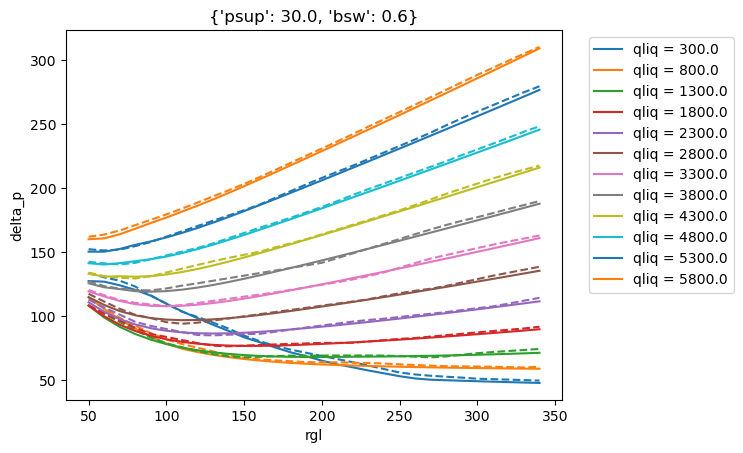

In [16]:
fixed_point = {
    'psup': 30.,
    'bsw': .6,
}

df_ = df[(df['psup'] == fixed_point['psup']) & (df['bsw'] == fixed_point['bsw'])]

for val in df_['qliq'].unique():
    df__ = df_[df_['qliq'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"qliq = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

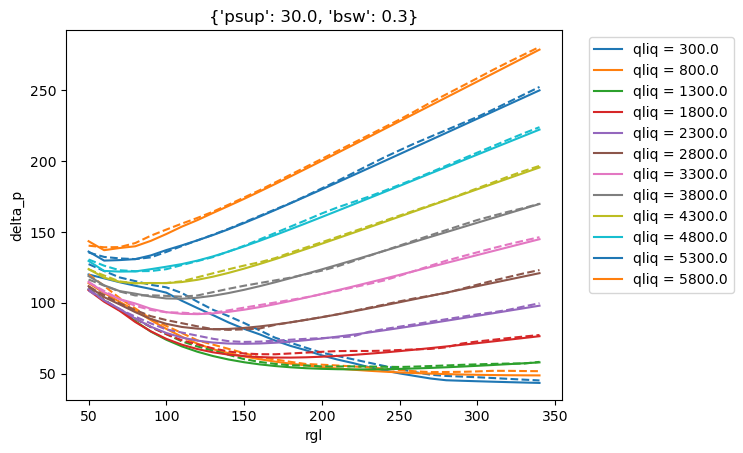

In [17]:
fixed_point = {
    'psup': 30.,
    'bsw': .3,
}

df_ = df[(df['psup'] == fixed_point['psup']) & (df['bsw'] == fixed_point['bsw'])]

for val in df_['qliq'].unique():
    df__ = df_[df_['qliq'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"qliq = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

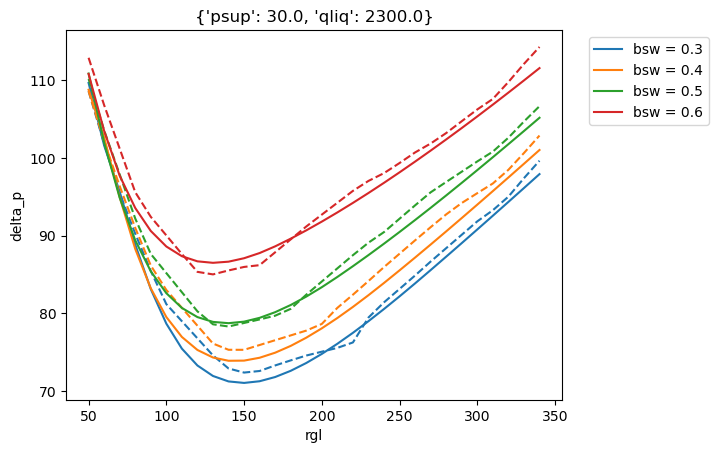

In [18]:
fixed_point = {
    'psup': 30.,
    'qliq': 2300.,
}

df_ = df[(df['psup'] == fixed_point['psup']) & (df['qliq'] == fixed_point['qliq'])]

for val in df_['bsw'].unique():
    df__ = df_[df_['bsw'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"bsw = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

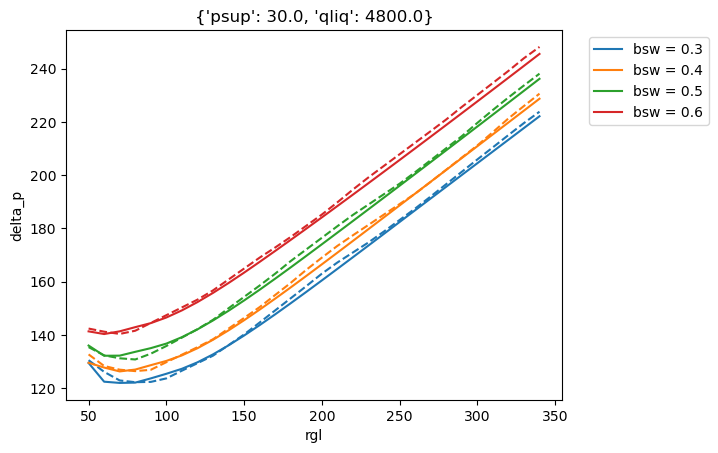

In [19]:
fixed_point = {
    'psup': 30.,
    'qliq': 4800.,
}

df_ = df[(df['psup'] == fixed_point['psup']) & (df['qliq'] == fixed_point['qliq'])]

for val in df_['bsw'].unique():
    df__ = df_[df_['bsw'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"bsw = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

In [20]:
df = pd.read_csv('well_data_large.csv', index_col=0)

df_norm = df.copy()

for col in df:
    # scale to [ 0, 1]
    df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    # scale to [-1, 1]
    df_norm[col] = 2 * df_norm[col] - 1

X = df_norm[['whp', 'q_gl', 'rgo', 'bsw']].values
y = df_norm['tpt_pressure'].values

X = jnp.array(X)
y = jnp.array(y)[...,None]

X.shape, y.shape

((14345, 4), (14345, 1))

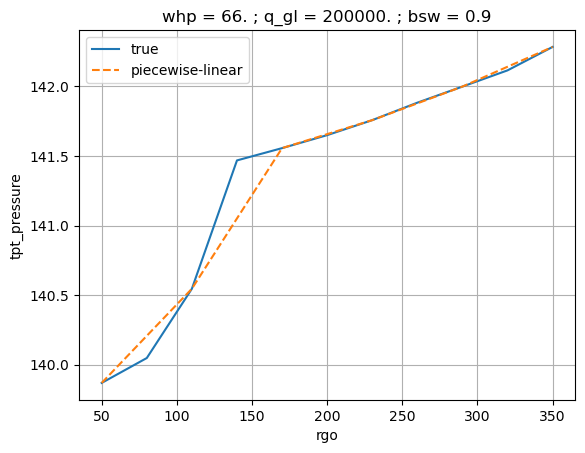

In [ ]:
from scipy.interpolate import interp1d

d = df[['tpt_pressure', 'rgo']][(df['whp'] == 66.) & (df['q_gl'] == 200000) & (df['bsw'] == 0.9)]

x = d['rgo'].values
y = d['tpt_pressure'].values

f = interp1d(x[::2], y[::2], kind='linear')

plt.plot(x, y, label='true')
# plt.scatter(x[::2], y[::2], label='piecewise-linear')
plt.plot(x, f(x), '--', label='piecewise-linear')
plt.title('whp = 66. ; q_gl = 200000. ; bsw = 0.9')
plt.ylabel('tpt_pressure')
plt.xlabel('rgo')
plt.legend()
plt.grid()
plt.show()

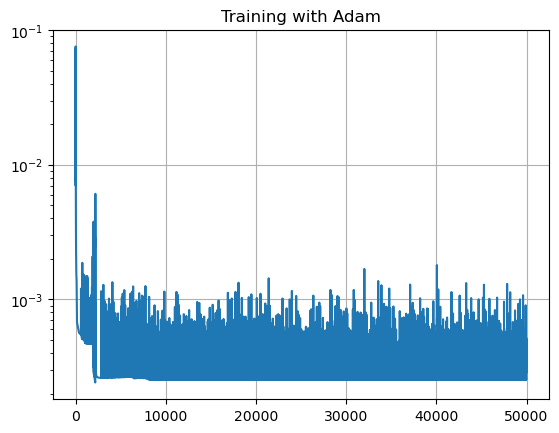

MAE = 0.65105736
max error = 8.137756


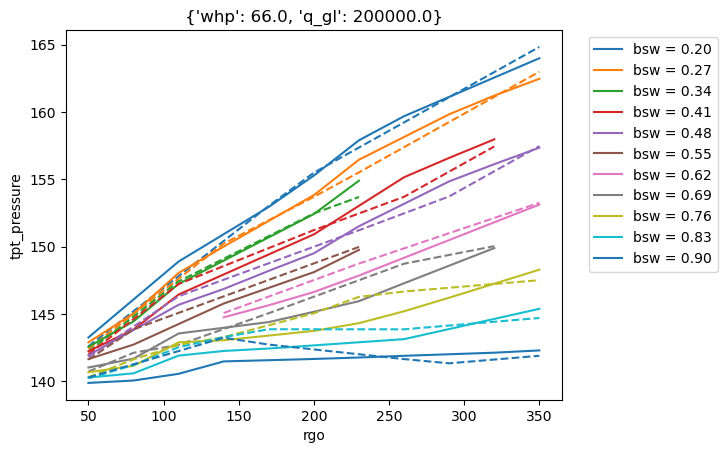

In [ ]:
key = random.PRNGKey(1)
net = NeuralNetwork([4, 20, 1], key)

optimizer = optax.adam(learning_rate=1e-1)

loss_values = net.fit(optimizer, optax.l2_loss, X, y, epochs=50000)

plt.plot(loss_values)
plt.yscale('log')
plt.title('Training with Adam')
plt.grid()
plt.show()

y_hat = vmap(net)(X)

y_hat = (y_hat + 1) / 2
y_hat = y_hat * (df['tpt_pressure'].max() - df['tpt_pressure'].min()) + df['tpt_pressure'].min()
df['tpt_pressure_hat'] = y_hat[:,0]

err = y_hat[:,0] - df['tpt_pressure'].values

print('MAE =', np.abs(err).mean())
print('max error =', np.abs(err).max())

fixed_point = {
    'whp': 66.,
    'q_gl': 200000.,
}

df_ = df[(df['whp'] == fixed_point['whp']) & (df['q_gl'] == fixed_point['q_gl'])]

for val in sorted(df_['bsw'].unique()):
    df__ = df_[df_['bsw'] == val]
    p = plt.plot(df__['rgo'], df__['tpt_pressure'], label=f"bsw = {val:.2f}")
    plt.plot(df__['rgo'], df__['tpt_pressure_hat'], '--', color=p[0].get_color())
plt.xlabel('rgo')
plt.ylabel('tpt_pressure')
plt.title(fixed_point)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()